In [1]:
# https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [1]:
! pip install nltk
! pip install pandas
! pip install scikit-learn

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyotikasingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Read the data using pandas
import pandas as pd
df = pd.read_csv("spam.csv", encoding ='latin1')
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [3]:
# Rename columns, remove unused columns
df.rename(columns={'v1': 'class', 'v2': 'text'}, inplace=True)
drop_columns = [col for col in df.columns if col not in ['class', 'text']]
df.drop(drop_columns, axis=1, inplace=True)
print(df.head())

  class                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
df.describe()

,class,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
df['class'].value_counts(normalize=True)
# 86.5% of the data belongs to class ham. There is a high class imbalance.

ham     0.865937
spam    0.134063
Name: class, dtype: float64

In [6]:
df["text"] # We see some informal language and extra punctuation. 

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [7]:
from nltk.corpus import stopwords
import string
import random
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = "".join([ch for ch in stop_free if ch not in exclude])
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

data = df.values.tolist()
cleaned_data = [(clean(doc), label) for label, doc in data]
cleaned_data = [(d, l) for d, l in cleaned_data if len(d)>5]
random.shuffle(cleaned_data)
x = [itm[0] for itm in cleaned_data]
y = [itm[1] for itm in cleaned_data]

In [8]:
from collections import Counter
print(Counter(y))

Counter({'ham': 4764, 'spam': 747})


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_x, valid_x, train_y, valid_y = train_test_split(x, y)

vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=5000)
X_train = vectorizer.fit_transform(train_x)
X_valid = vectorizer.transform(valid_x)


In [10]:
X_train.data


array([1.        , 1.        , 1.        , ..., 0.55809467, 1.        ,
       1.        ])


    Best alpha     : 0.4
    Avg. Precision : 0.954273785981103
    Avg. Recall    : 0.8729883813235189
    Avg. F1        : 0.9080138649208602

    
Per class evaluation
    Classes        : ['ham' 'spam']
    Precision      : [0.96260163 0.94594595]
    Recall         : [0.99328859 0.75268817]
    F1             : [0.97770438 0.83832335]


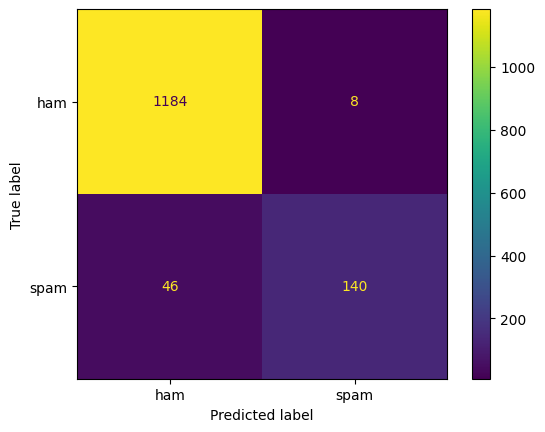

In [11]:
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def multinomialBN_model(X_train, train_y, X_valid, valid_y, alpha=1.0):
    model = MultinomialNB(alpha=alpha).fit(X_train, train_y)
    y_pred = model.predict(X_valid)
    (
        prec, recall, f1, class_size
    ) = precision_recall_fscore_support(
        valid_y, y_pred, average=None, labels=model.classes_
    )
    scores = {
        "class_order": model.classes_, 
        "precision": prec, 
        "recall": recall, 
        "f1": f1, 
        "avg prec": np.mean(prec), 
        "avg recall": np.mean(recall), 
        "avg f1": np.mean(f1)
    }
    return model, scores, y_pred

models = {}
for alpha in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    models[alpha] = multinomialBN_model(X_train, train_y, X_valid, valid_y, alpha=alpha)
f1_max = max([models[alpha][1]["avg f1"] for alpha in models])
best_alpha, best_model, best_score, y_pred = [(alpha, models[alpha][0], models[alpha][1], models[alpha][2])  for alpha in models if models[alpha][1]["avg f1"]==f1_max][0]
print(f"""
    Best alpha     : {best_alpha}
    Avg. Precision : {best_score["avg prec"]}
    Avg. Recall    : {best_score["avg recall"]}
    Avg. F1        : {best_score["avg f1"]}""")
print(f"""
    \nPer class evaluation
    Classes        : {best_score["class_order"]}
    Precision      : {best_score["precision"]}
    Recall         : {best_score["recall"]}
    F1             : {best_score["f1"]}""")

cm = confusion_matrix(valid_y, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [17]:
new_samples = [
    "You have completed your order. Please check your email for a refund receipt for $50.",
    "Win lottery worth $2 Million! click here to participate for free.",
    "Please send me the report by tomorrow morning. Thanks.",
    "You have been selected for a free $500 prepaid card."
]
sample_vects = vectorizer.transform([clean(doc) for doc in new_samples])
print("Predicted class for samples: ", best_model.predict(sample_vects))
print(
    "Probabilities: \n", 
    best_model.classes_, "\n", 
    best_model.predict_proba(sample_vects)
)

Predicted class for samples:  ['ham' 'spam' 'ham' 'spam']
Probabilities: 
 ['ham' 'spam'] 
 [[0.70874105 0.29125895]
 [0.10782766 0.89217234]
 [0.94339795 0.05660205]
 [0.37811938 0.62188062]]


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(
    MultinomialNB(alpha=best_alpha),
    X_train, train_y,
    #scoring="recall",
    cv=5)

array([0.94921403, 0.96251511, 0.94558646, 0.95641646, 0.95157385])

In [15]:
# Checking cross validation recall scores per class
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

vect = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=5000)

scoring = {
    'recall_spam': make_scorer(
        recall_score, average = None, labels=["spam"]
    ), 
    'recall_ham': make_scorer(
        recall_score, average = None, labels=["ham"]
    )
}

cross_validate(
    MultinomialNB(alpha=best_alpha), 
    vect.fit_transform(x),
    y,
    scoring=scoring, 
    cv=5
)
# >> 'test_recall_spam': array([0.64666667, 0.69333333, 0.73154362, 0.67114094, 0.7852349 ]),
# >> 'test_recall_ham': array([0.98860104, 0.99378238, 0.99585492, 0.99067358, 0.98963731])}

{'fit_time': array([0.00408673, 0.00373816, 0.00417686, 0.00382996, 0.00376606]),
 'score_time': array([0.00767422, 0.00742602, 0.00672722, 0.00753498, 0.00731206]),
 'test_recall_spam': array([0.74      , 0.72483221, 0.75838926, 0.65100671, 0.68666667]),
 'test_recall_ham': array([0.99265477, 0.98426023, 0.9884575 , 0.99370409, 0.99369748])}

In [16]:
from sklearn import metrics
metrics.accuracy_score(y_pred, valid_y)


0.9608127721335269